In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import yellowbrick.features as yb
import yellowbrick.target as yt
import yellowbrick.regressor as yr
import sklearn
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
training_data = pd.read_csv('data/train_base.csv')
test_data = pd.read_csv('data/test_base.csv')

In [9]:
scaled_training_data = pd.read_csv("data/training_min_max_scaled.csv")
scaled_test_data = pd.read_csv("data/test_min_max_scaled.csv")

In [65]:
training_data.head()

,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0


In [6]:
test_data.head()

,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,31,1398.91,554.42,47.23,521.79,112,0
1,2,49,1410.83,553.52,47.67,521.74,98,0
2,3,126,1418.89,552.59,47.88,520.83,69,0
3,4,106,1406.88,552.64,47.65,521.88,82,0
4,5,98,1419.36,553.29,47.46,521.00,91,0


In [36]:
# Identify missing values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         20631 non-null  int64  
 1   Cycle      20631 non-null  int64  
 2   S1         20631 non-null  float64
 3   S2         20631 non-null  float64
 4   S3         20631 non-null  float64
 5   S4         20631 non-null  float64
 6   TTF        20631 non-null  int64  
 7   TTF_LABEL  20631 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


AttributeError: 'NoneType' object has no attribute 'T'

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         100 non-null    int64  
 1   Cycle      100 non-null    int64  
 2   S1         100 non-null    float64
 3   S2         100 non-null    float64
 4   S3         100 non-null    float64
 5   S4         100 non-null    float64
 6   TTF        100 non-null    int64  
 7   TTF_LABEL  100 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


In [9]:
training_data.describe()

,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,1408.933782,553.367711,47.541168,521.413470,107.807862,0.150259
std,29.227633,68.880990,9.000605,0.885092,0.267087,0.737553,68.880990,0.357334
min,1.000000,1.000000,1382.250000,549.850000,46.850000,518.690000,0.000000,0.000000
25%,26.000000,52.000000,1402.360000,552.810000,47.350000,520.960000,51.000000,0.000000
50%,52.000000,104.000000,1408.040000,553.440000,47.510000,521.480000,103.000000,0.000000
75%,77.000000,156.000000,1414.555000,554.010000,47.700000,521.950000,155.000000,0.000000
max,100.000000,362.000000,1441.490000,556.060000,48.530000,523.380000,361.000000,1.000000


In [6]:
# Define columns
index_columns = ['ID', 'Cycle']
features = ['S1', 'S2', 'S3', 'S4']
target = ['TTF']

In [62]:
id_statistics = training_data["ID"].describe()
cycle_statistics = training_data[index_columns].groupby('ID').max().describe()
pd.concat([id_statistics, cycle_statistics], axis=1)

,ID,Cycle
count,20631.000000,100.000000
mean,51.506568,206.310000
std,29.227633,46.342749
min,1.000000,128.000000
25%,26.000000,177.000000
50%,52.000000,199.000000
75%,77.000000,229.250000
max,100.000000,362.000000


In [20]:
training_data[features].describe()

,S1,S2,S3,S4
count,20631.000000,20631.000000,20631.000000,20631.000000
mean,1408.933782,553.367711,47.541168,521.413470
std,9.000605,0.885092,0.267087,0.737553
min,1382.250000,549.850000,46.850000,518.690000
25%,1402.360000,552.810000,47.350000,520.960000
50%,1408.040000,553.440000,47.510000,521.480000
75%,1414.555000,554.010000,47.700000,521.950000
max,1441.490000,556.060000,48.530000,523.380000


<AxesSubplot:xlabel='TTF', ylabel='Count'>

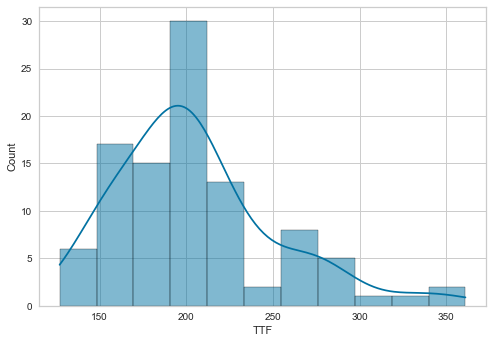

In [68]:
# Plot histogram of target variable
ttf_by_id = training_data.groupby('ID')['TTF'].max()
sns.histplot(ttf_by_id, kde=True)

Text(0, 0.5, 'Frequency')

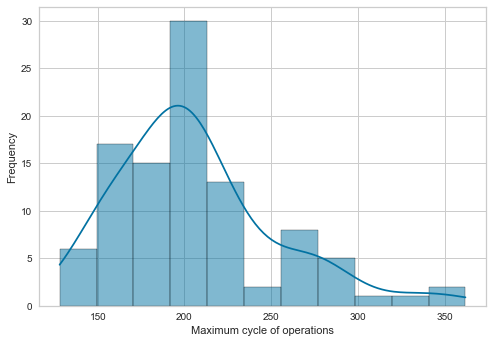

In [69]:
# Plot histogram of target variable
ttf_by_id = training_data.groupby('ID')['Cycle'].max()
ax = sns.histplot(ttf_by_id, kde=True)
ax.set_xlabel('Maximum cycle of operations')
ax.set_ylabel('Frequency')

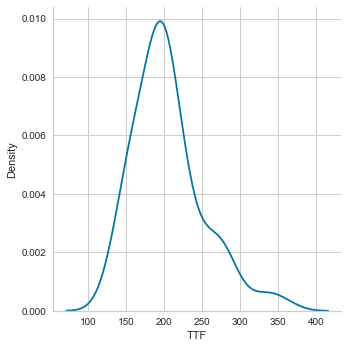

In [47]:
sns.displot(ttf_by_id, kind='kde')

In [7]:
X_train = training_data[features]
y_train = training_data[target]

In [29]:
training_data[training_data.ID.isin([1, 10])]

,ID,Cycle,S1,S2,S3,S4,TTF,TTF_LABEL
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0
...,...,...,...,...,...,...,...,...
2131,10,218,1426.21,551.45,48.09,520.23,4,1
2132,10,219,1424.54,552.03,48.06,519.83,3,1
2133,10,220,1422.76,551.73,47.95,520.23,2,1
2134,10,221,1432.13,551.77,48.08,519.22,1,1


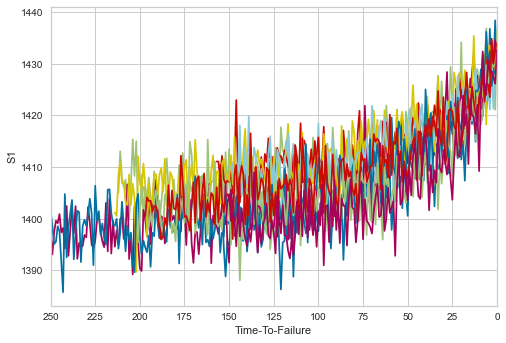

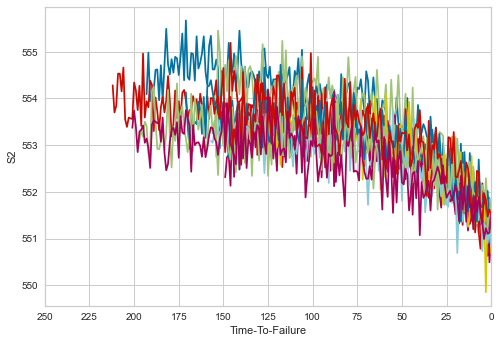

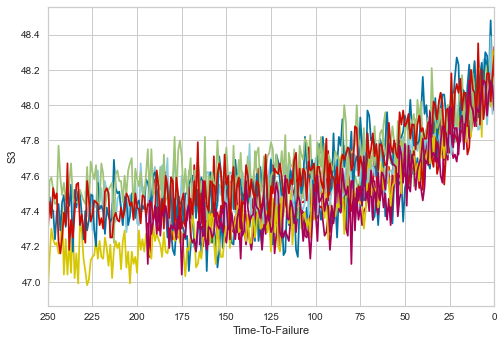

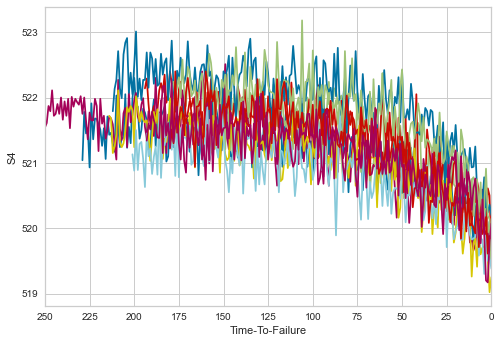

In [8]:

def plot_sensor(sensor_name):
    engines = np.random.choice(range(1,101), 10, replace=False)
    plt.figure()
    for engine in engines:
        fig = sns.lineplot(x='TTF', y=sensor_name, data=training_data[training_data['ID'] == engine], palette='pastel')

    fig.set(xlim=(250, 0))  # reverse the x-axis so RUL counts down to zero
    fig.set(xticks=np.arange(0, 275, 25))
    fig.set(ylabel=sensor_name)
    fig.set(xlabel='Time-To-Failure')

for sensor in features:
    plot_sensor(sensor)

In [49]:
X_train.skew()

S1    0.443194
S2   -0.394329
S3    0.469329
S4   -0.442407
dtype: float64

In [50]:
X_train.kurtosis()

S1   -0.163681
S2   -0.157949
S3   -0.172192
S4   -0.144917
dtype: float64

In [56]:
from scipy.stats import kurtosis, skew, kurtosistest
skew(X_train, bias=False)

array([ 0.44319434, -0.39432894,  0.46932909, -0.44240724])

In [60]:
kurtosis(X_train)

array([-0.16393201, -0.15820175, -0.17244096, -0.14517226])

/Users/tanmayk/.pyenv/versions/3.9.1/envs/SLM-Code/lib/python3.9/site-packages/scipy/stats/morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


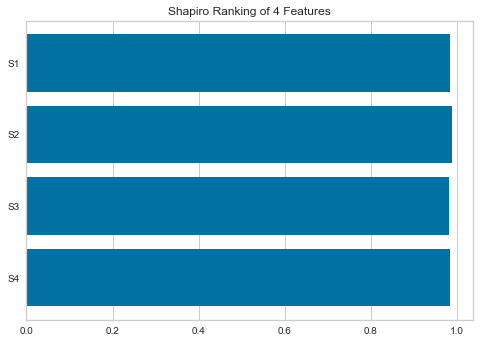

<AxesSubplot:title={'center':'Shapiro Ranking of 4 Features'}>

In [30]:
visualizer = yb.Rank1D(algorithm="shapiro")
visualizer.fit(X_train, y_train)
visualizer.transform(X_train)
visualizer.show()

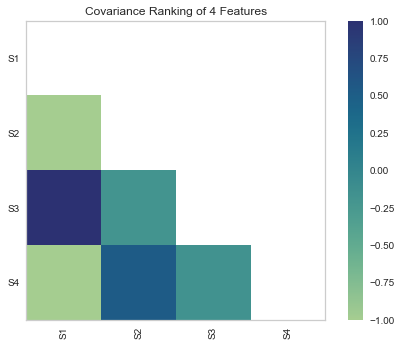

0.0

<Figure size 576x396 with 0 Axes>

In [188]:
visualizer = yb.Rank2D(algorithm="covariance", colormap="crest")
visualizer.fit_transform(training_data[features])
visualizer.show()
visualizer.fig.patch.get_linewidth()

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 1.0)

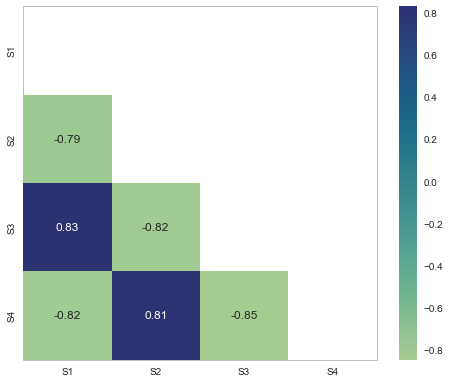

In [77]:
fig, ax = plt.subplots(figsize=(8, 6.5))
ax.patch.set_edgecolor('gray')  
ax.patch.set_linewidth('.5') 
correlation_matrix = training_data[features].corr(method='pearson')
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix, annot=True, mask=mask, ax=ax, square=True, cmap='crest')
ax.patch.get_edgecolor()


In [75]:
training_data.corrwith(training_data['TTF'])

ID           0.078753
Cycle       -0.736241
S1          -0.678948
S2           0.657223
S3          -0.696228
S4           0.671983
TTF          1.000000
TTF_LABEL   -0.566596
dtype: float64

<AxesSubplot:>

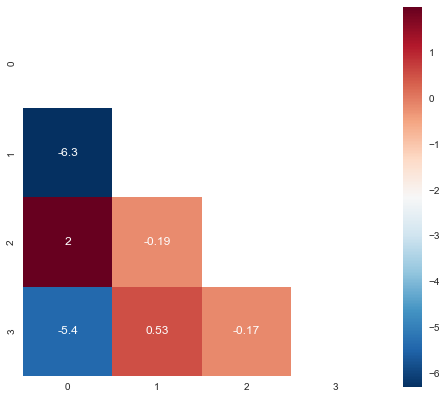

In [177]:
fig, ax = plt.subplots(figsize=(8, 7))
correlation_matrix = visualizer.ranks_
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix, annot=True, mask=mask, ax=ax, square=True, cmap='RdBu_r')

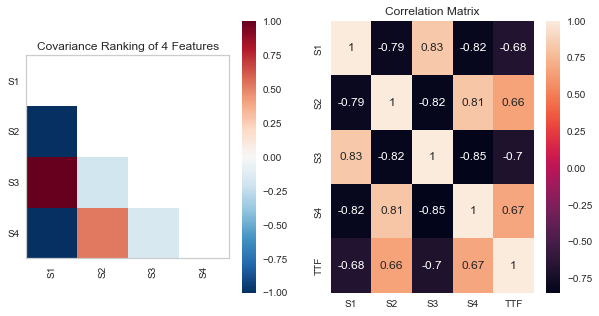

<Figure size 576x396 with 0 Axes>

In [182]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
visualizer = yb.Rank2D(algorithm="covariance", ax=axs[0])
visualizer.fit_transform(training_data[features])
sns.heatmap(training_data[features + target].corr(method='pearson'), annot=True, ax=axs[1]).set_title('Correlation Matrix')
visualizer.show()

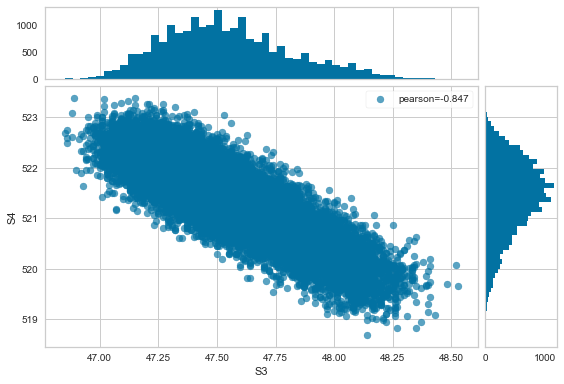

<AxesSubplot:xlabel='S3', ylabel='S4'>

In [18]:
visualizer = yb.JointPlotVisualizer(columns=['S3', 'S4'])
visualizer.fit_transform(X_train, y_train)
visualizer.show()

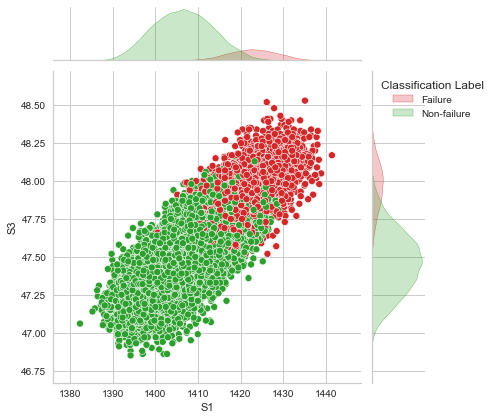

In [6]:
fig = sns.jointplot(x='S1', y='S3', data=training_data, hue='TTF_LABEL', palette=['tab:green', 'tab:red'], legend=False)
plt.legend(loc=2,title='Classification Label', labels=['Failure', 'Non-failure'])
plt.show(fig)

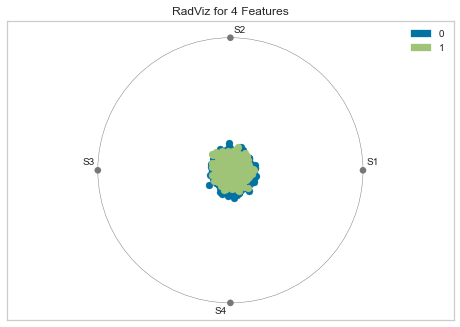

<AxesSubplot:title={'center':'RadViz for 4 Features'}>

In [10]:
visualizer = yb.RadViz(classes=[0, 1])
visualizer.fit(X_train, scaled_training_data['TTF_LABEL'])
visualizer.transform(X_train)
visualizer.show()

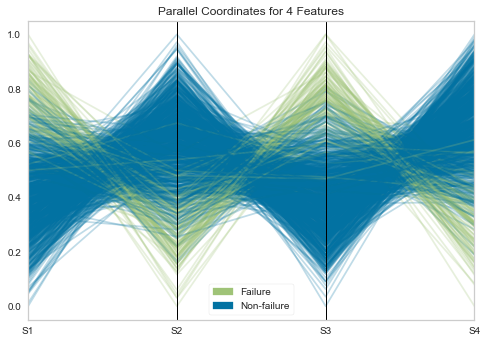

,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19
...,...,...,...,...
20626,1428.63,551.43,48.07,519.49
20627,1433.58,550.86,48.04,519.68
20628,1428.18,550.94,48.09,520.01
20629,1426.53,550.68,48.39,519.67


In [24]:
visualizer = yb.ParallelCoordinates(classes=['Non-failure', 'Failure'], sample=0.05, shuffle=True, normalize='minmax')
visualizer.fit_transform_show(X_train, training_data['TTF_LABEL'])

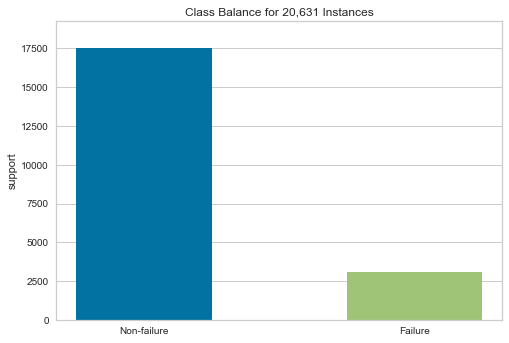

<AxesSubplot:title={'center':'Class Balance for 20,631 Instances'}, ylabel='support'>

In [10]:
visualizer= yt.ClassBalance(labels=['Non-failure', 'Failure'])
visualizer.fit(training_data['TTF_LABEL'])
visualizer.show()

In [12]:
visualizer.support_[0] / ( visualizer.support_[0] + visualizer.support_[1])

0.8497406814987155

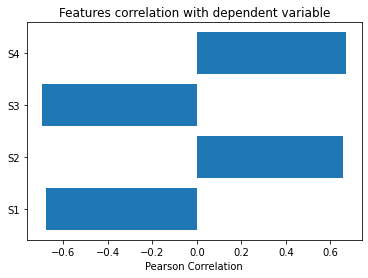

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [261]:
visualizer = yt.FeatureCorrelation(labels=features)
visualizer.fit(X_train, training_data['TTF'])
visualizer.show()

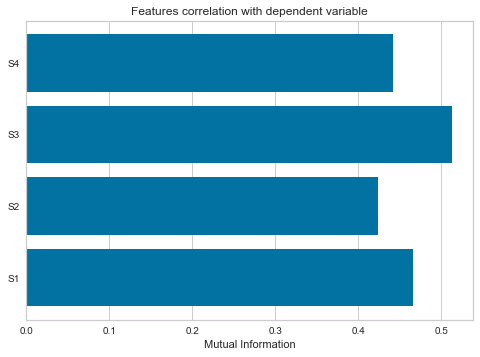

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [11]:
visualizer = yt.FeatureCorrelation(method='mutual_info-classification', labels=features)
visualizer.fit(X_train, training_data['TTF'])
visualizer.show()

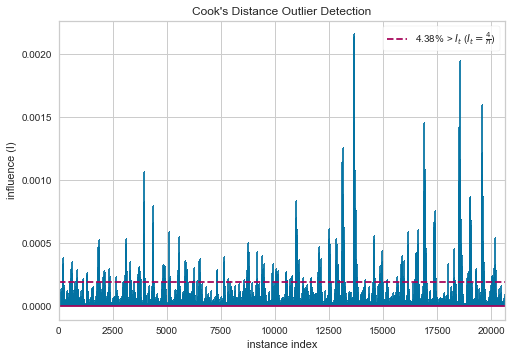

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [12]:
visualizer= yr.CooksDistance()
visualizer.fit(X_train, training_data['TTF'])
visualizer.show()

In [13]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_pruned, y_pruned = X_train[i_less_influential], y_train[i_less_influential]

In [41]:
plt.savefig('media/image3.png')

<Figure size 576x396 with 0 Axes>

In [141]:
visualizer.outlier_percentage_ / 100 *  training_data.shape[0]

904.0

In [43]:
visualizer.influence_threshold_

0.0001938829916145606

In [66]:
k = 1.5
to_remove = {}
for col in features:
    quantiles = training_data[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    lower_bound = q1 - k*iqr
    upper_bound = q3 + k*iqr
    num_out_outliers_index = training_data[(training_data[col] > upper_bound) | (training_data[col] < lower_bound)].index
    to_remove[col] = num_out_outliers_index

In [45]:
to_remove

{'S1': Int64Index([  654,   845,  1112,  1114,  1300,  1303,  1549,  1555,  1562,
              1910,
             ...
             18850, 19006, 19009, 19263, 19543, 19546, 19547, 19548, 20429,
             20627],
            dtype='int64', length=120),
 'S2': Int64Index([  183,   188,   190,   476,  1115,  1301,  1303,  1711,  2373,
              2708,
             ...
             19256, 19879, 19887, 20428, 20430, 20618, 20627, 20628, 20629,
             20630],
            dtype='int64', length=110),
 'S3': Int64Index([  186,   189,   191,   473,   476,   656,  1103,  1110,  1112,
              1113,
             ...
             19880, 20242, 20244, 20245, 20425, 20426, 20428, 20430, 20618,
             20629],
            dtype='int64', length=167),
 'S4': Int64Index([ 1291,  1294,  1299,  1302,  1303,  1536,  1555,  1561,  1562,
              1703,
             ...
             19010, 19551, 19879, 19883, 19887, 20244, 20423, 20425, 20427,
             20630],
            dtyp

In [67]:
combined = set()
for indexes in to_remove.values():
    combined.update(set(indexes))
print("Removed:", len(combined))
print(f"This is {len(combined) / training_data.shape[0] * 100}% of our dataset")

Removed: 427
This is 2.0697009354854345% of our dataset


In [68]:
num_out_outliers = training_data.loc[list(combined)]
custom_groups = {}
for key, values in to_remove.items():
    removed_obsv = training_data.loc[values]
    custom_groups[key] = removed_obsv

In [69]:
summary_table = pd.DataFrame(["mean", "count", "min", "max", "std"], columns=["metric"])
summary_table.set_index("metric", inplace=True)
for key in custom_groups.keys():
    summary_table[key] = np.NaN

In [70]:
for key, group in custom_groups.items():
    summary_table.loc["mean", key] = group[key].mean()
    summary_table.loc["count", key] = group[key].count()
    summary_table.loc["min", key] = group[key].min()
    summary_table.loc["max", key] = group[key].max()
    summary_table.loc["std", key] = group[key].std()
summary_table

,S1,S2,S3,S4
metric,,,,
mean,1434.505750,550.855818,48.288503,519.292397
count,120.000000,110.000000,167.000000,146.000000
min,1382.250000,549.850000,48.230000,518.690000
max,1441.490000,556.060000,48.530000,519.470000
std,5.109626,0.720147,0.057693,0.147144


In [71]:
quantiles_dict = {}
for col in features:
    quantiles = training_data[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    quantiles_dict[col] = [q1, q3, iqr]

In [52]:
quantiles_dict

{'S1': [1402.36, 1414.5549999999998, 12.194999999999936],
 'S2': [552.81, 554.01, 1.2000000000000455],
 'S3': [47.35, 47.7, 0.3500000000000014],
 'S4': [520.96, 521.95, 0.9900000000000091]}

In [72]:
currently_removed = len(combined)
removed_count = [len(combined)]
removed_indexes = {}
k_lst = [1.5]
one_percent = int(0.01 * training_data.shape[0]) # finding the one percent length of the data
while currently_removed > one_percent:
    k += 0.1
    k_lst.append(k)
    for col in features: # identifyin outliers with IQR multiplier equal to k
        q1 = quantiles_dict[col][0]
        q3 = quantiles_dict[col][1]
        iqr = quantiles_dict[col][2]
        lower_bound = q1 - k*iqr
        upper_bound = q3 + k*iqr
        num_out_outliers_index = training_data[(training_data[col] > upper_bound) | (training_data[col] < lower_bound)].index
        to_remove[col] = num_out_outliers_index

    combined = set()
    for indexes in to_remove.values():
        combined.update(set(indexes))
    removed_indexes[k] = list(combined)
    currently_removed = len(combined)
    removed_count.append(currently_removed)

In [73]:
k_lst

[1.5, 1.6, 1.7000000000000002]

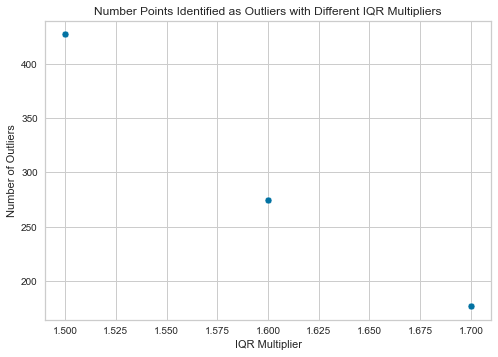

In [74]:
ax = sns.scatterplot(x=k_lst, y=removed_count)
ax.set(xlabel="IQR Multiplier", ylabel="Number of Outliers", title="Number Points Identified as Outliers with Different IQR Multipliers")
plt.show()

In [83]:
inv_cov = np.linalg.matrix_power(X_train.cov(), -1)
mean = np.mean(X_train)
mahalanobis_houses = X_train.copy()
mahalanobis_houses["mahalanobis_distance"] = np.NaN

In [84]:
for index, values in mahalanobis_houses.iterrows():
    values = values[0:len(features)]
    mahalanobis_houses.loc[index, "mahalanobis_distance"] = mahalanobis(values, mean, inv_cov)**2

In [86]:
mahalanobis_threshold = chi2.ppf(0.99, mahalanobis_houses.shape[1] - 1)
mahalanobis_outliers = mahalanobis_houses[mahalanobis_houses["mahalanobis_distance"] > mahalanobis_threshold].index
print("Removed:", len(mahalanobis_outliers))
print(f"This is {len(mahalanobis_outliers) / X_train.shape[0] * 100}% of our dataset")

Removed: 188
This is 0.9112500605884348% of our dataset


In [87]:
X_train.loc[mahalanobis_outliers].sample(n=20, random_state=20)

,S1,S2,S3,S4
14549,1436.24,550.68,48.10,520.18
5834,1395.07,552.93,47.17,521.51
10277,1405.02,552.43,47.55,520.29
14929,1431.14,550.35,48.07,519.52
20085,1426.47,553.18,48.16,520.41
10119,1419.91,552.63,48.27,520.24
7509,1426.16,551.67,48.52,520.07
11929,1423.18,552.83,48.21,519.84
13428,1436.56,550.92,48.18,520.18
3746,1414.90,554.00,47.84,521.97


<AxesSubplot:xlabel='S4'>

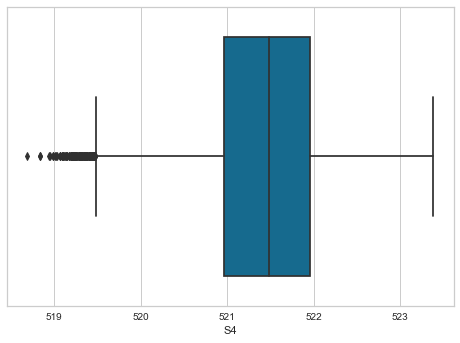

In [98]:
sns.boxplot(x=X_train['S4'])

<AxesSubplot:xlabel='S4'>

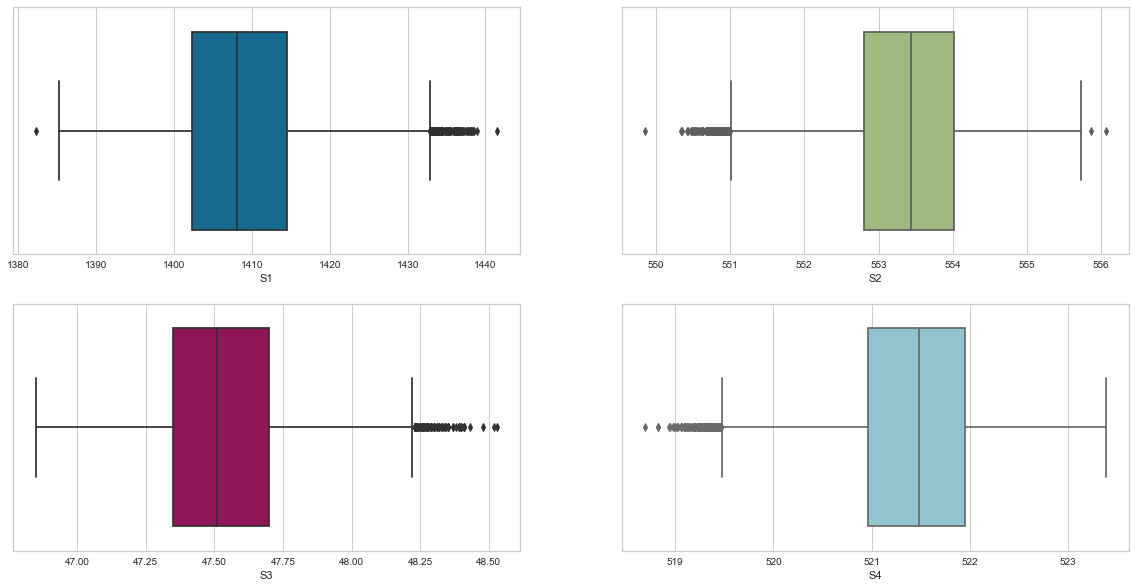

In [138]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
sns.boxplot(x=X_train['S1'], ax=axs[0, 0], color="#0272a2")
sns.boxplot(x=X_train['S2'], ax=axs[0, 1], color="#9fc377")
sns.boxplot(x=X_train['S3'], ax=axs[1, 0], color="#a50258")
sns.boxplot(x=X_train['S4'], ax=axs[1, 1], color="#88cada")

In [125]:
print(sns.color_palette().as_hex())

['#0272a2', '#9fc377', '#ca0b03', '#a50258', '#d7c703', '#88cada']


In [204]:
sns.reset_orig()

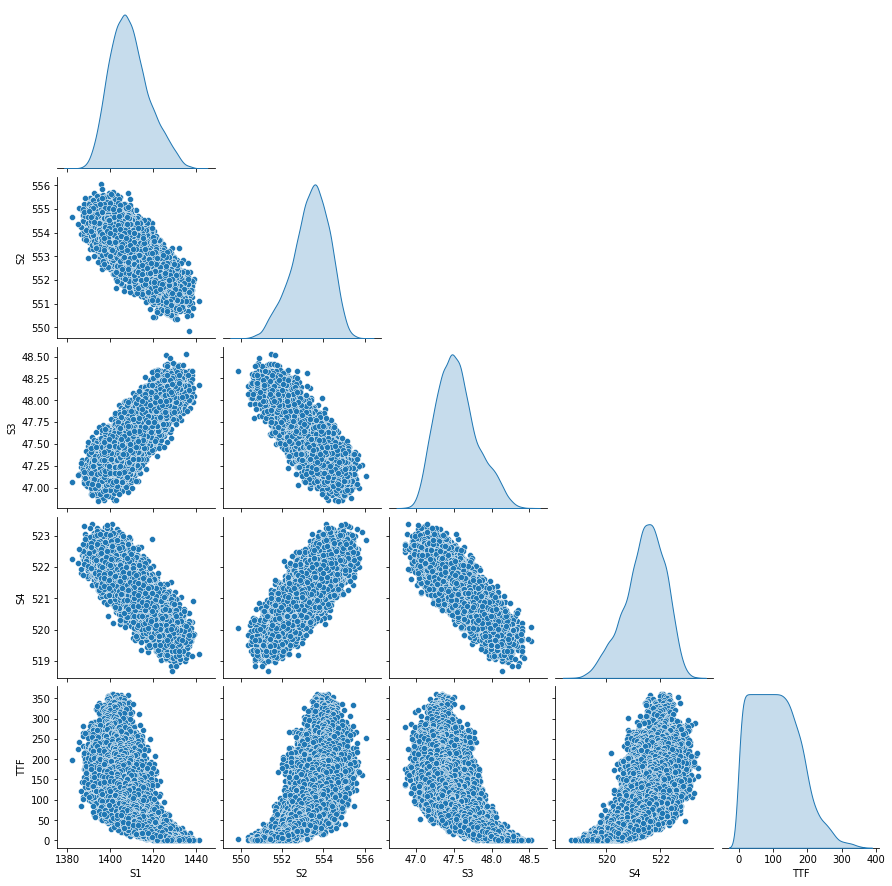

In [207]:
sns.pairplot(
    training_data[features + target],
    corner=True,
    diag_kind="kde"
)


In [214]:
X_train.std().sort_values(ascending=False)

S1    9.000605
S2    0.885092
S4    0.737553
S3    0.267087
dtype: float64

Text(0, 0.5, 'Standard Deviation')

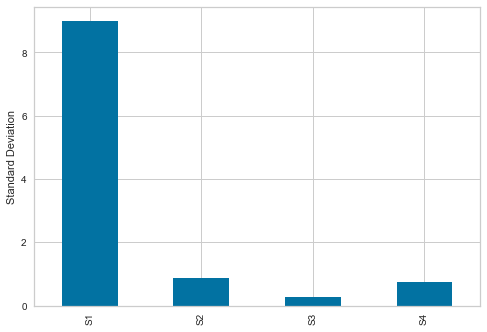

In [33]:
ax = X_train.std().plot(kind='bar')
ax.set_ylabel("Standard Deviation")

Text(0, 0.5, 'Logarithmic Standard Deviation')

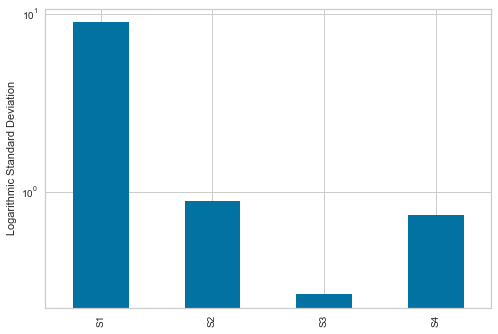

In [34]:
ax = X_train.std().plot(kind='bar', logy=True)
ax.set_ylabel("Logarithmic Standard Deviation")

In [80]:
y_train

,TTF
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [86]:
from sklearn.ensemble import RandomForestRegressor

single_rf = RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X_train, y_train)
y_pred = single_rf.predict(X_train)

/var/folders/dy/7cnns26d2j52cnsqr1ms5fpm0000gn/T/ipykernel_15034/356486067.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  single_rf.fit(X_train, y_train)


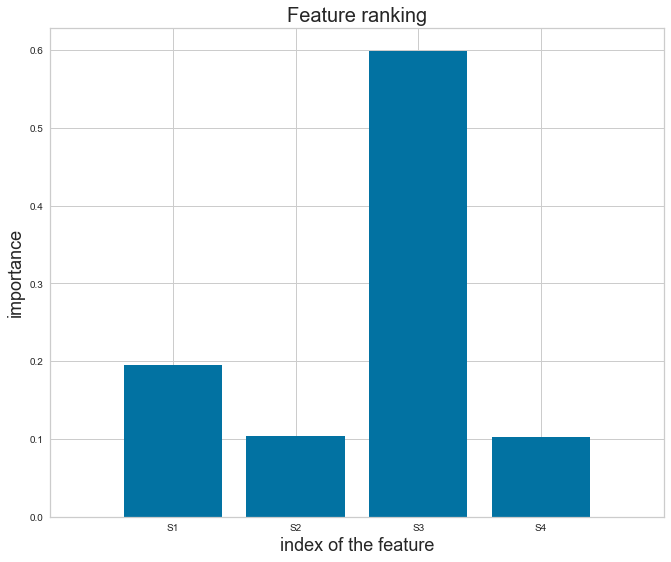

In [89]:
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X_train.shape[1]), importances, color="b", align="center")
plt.xticks(range(X_train.shape[1]), feature_names) #feature_names, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

s4, s7, s12, s11